<a href="https://colab.research.google.com/github/srinivasiyengar/NewCastle-University-Internship/blob/main/CARE_Model_(Image_Denoising_in_2_D_images)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                                        CARE model for Image restoration in 2-D images. 

Installing CSBDeep - a deep learning toolbox for microscopy image restoration and analysis

In [1]:
pip install csbdeep

     |████████████████████████████████| 71kB 4.9MB/s 
     |████████████████████████████████| 378kB 12.2MB/s 
     |████████████████████████████████| 51kB 4.3MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


importing the required modules:

In [3]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
from tifffile import imread
from csbdeep.utils import download_and_extract_zip_file, plot_some
from csbdeep.data import RawData, create_patches

                                                         Example data

In [5]:
download_and_extract_zip_file (
    url       = 'http://csbdeep.bioimagecomputing.com/example_data/snr_7_binning_2.zip',
    targetdir = 'data',
    verbose   = 1,
)

Files missing, downloading... extracting... done.


In [6]:
y = imread('data/train/GT/img_0010.tif')
x = imread('data/train/low/img_0010.tif')
print('image size =', x.shape)

image size = (256, 256)


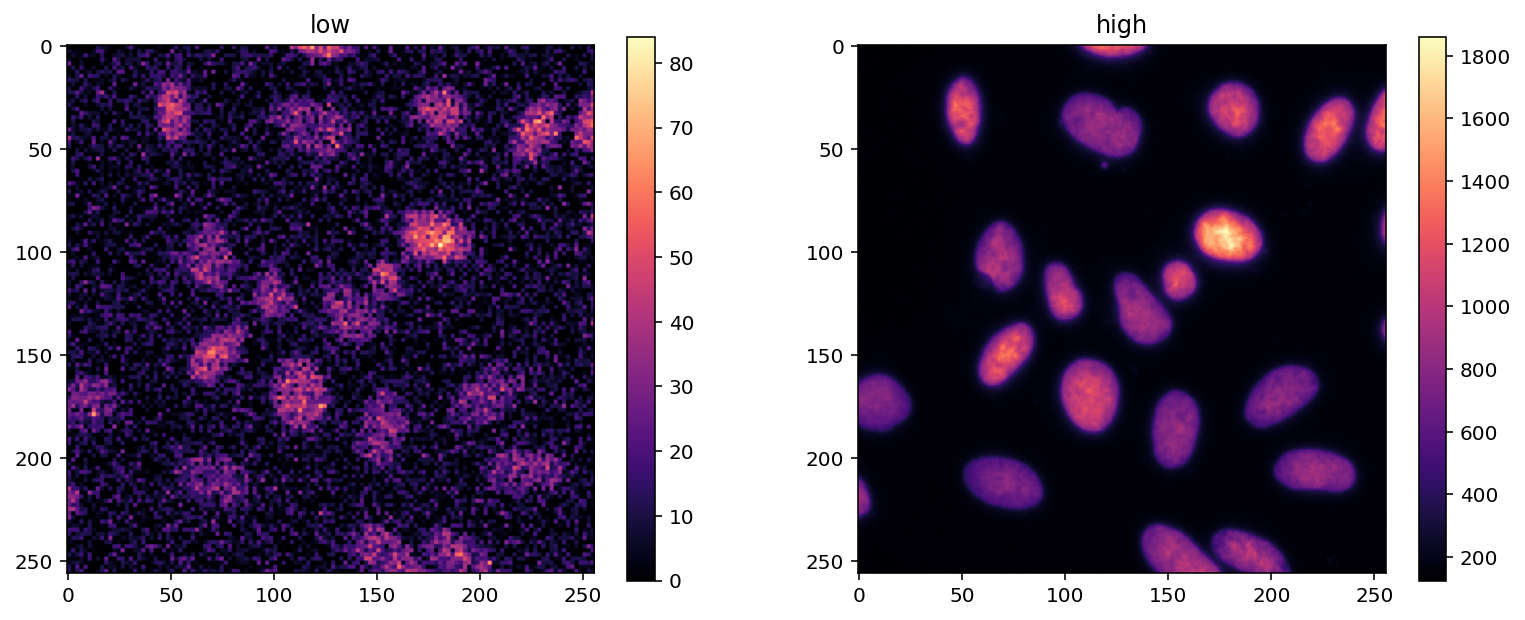

In [7]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.imshow(x, cmap  ="magma")
plt.colorbar()
plt.title("low")
plt.subplot(1,2,2)
plt.imshow(y, cmap  ="magma")
plt.colorbar()
plt.title("high");

                                                            Generate training data for CARE

In [8]:
raw_data = RawData.from_folder (
    basepath    = 'data/train',
    source_dirs = ['low'],
    target_dir  = 'GT',
    axes        = 'YX',
)

In [9]:
from csbdeep.data import no_background_patches, norm_percentiles, sample_percentiles
X, Y, XY_axes = create_patches (
    raw_data            = raw_data,
    patch_size          = (128,128),
    patch_filter        = no_background_patches(0),
    n_patches_per_image = 2,
    save_file           = 'data/my_training_data.npz',
)

 2457 raw images x    1 transformations   =  2457 images
 2457 images     x    2 patches per image =  4914 patches in total
Input data:
data/train: target='GT', sources=['low'], axes='YX', pattern='*.tif*'
Transformations:
1 x Identity
Patch size:
128 x 128


100%|██████████| 2457/2457 [00:18<00:00, 134.52it/s]


Saving data to data/my_training_data.npz.


In [11]:
assert X.shape == Y.shape
print("shape of X,Y =", X.shape)
print("axes  of X,Y =", XY_axes)


shape of X,Y = (4914, 1, 128, 128)
axes  of X,Y = SCYX


                                                                      example patches

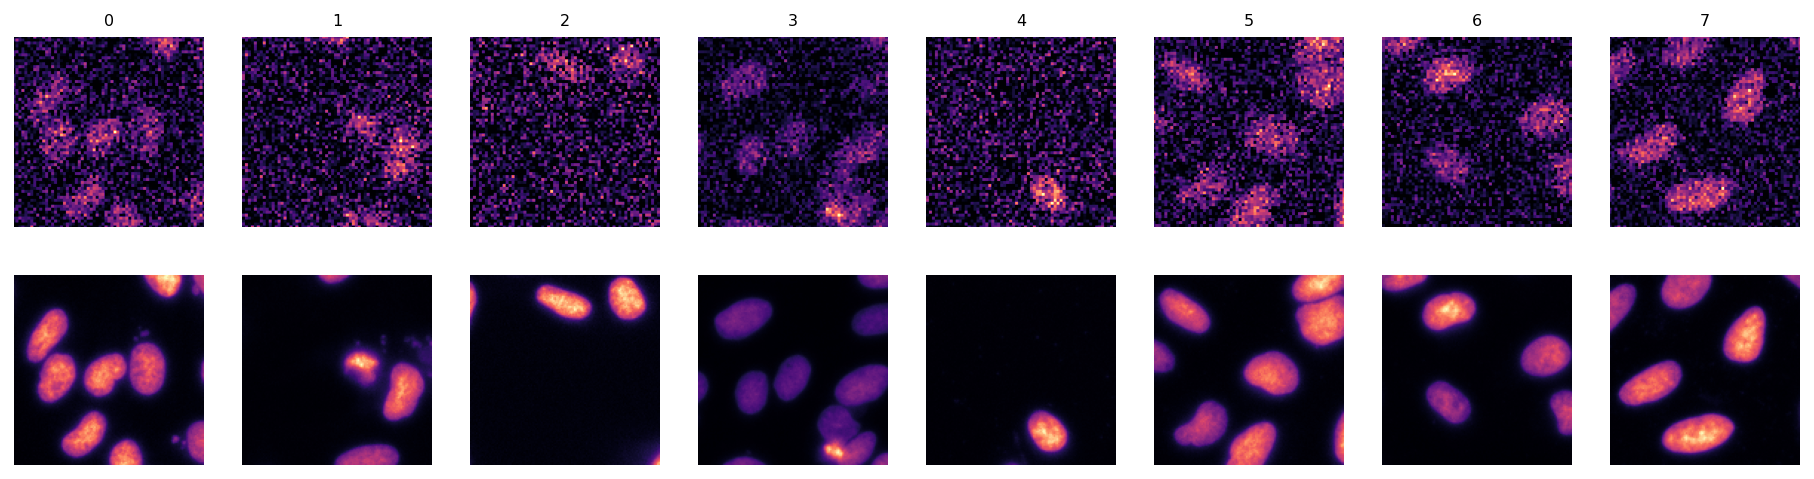

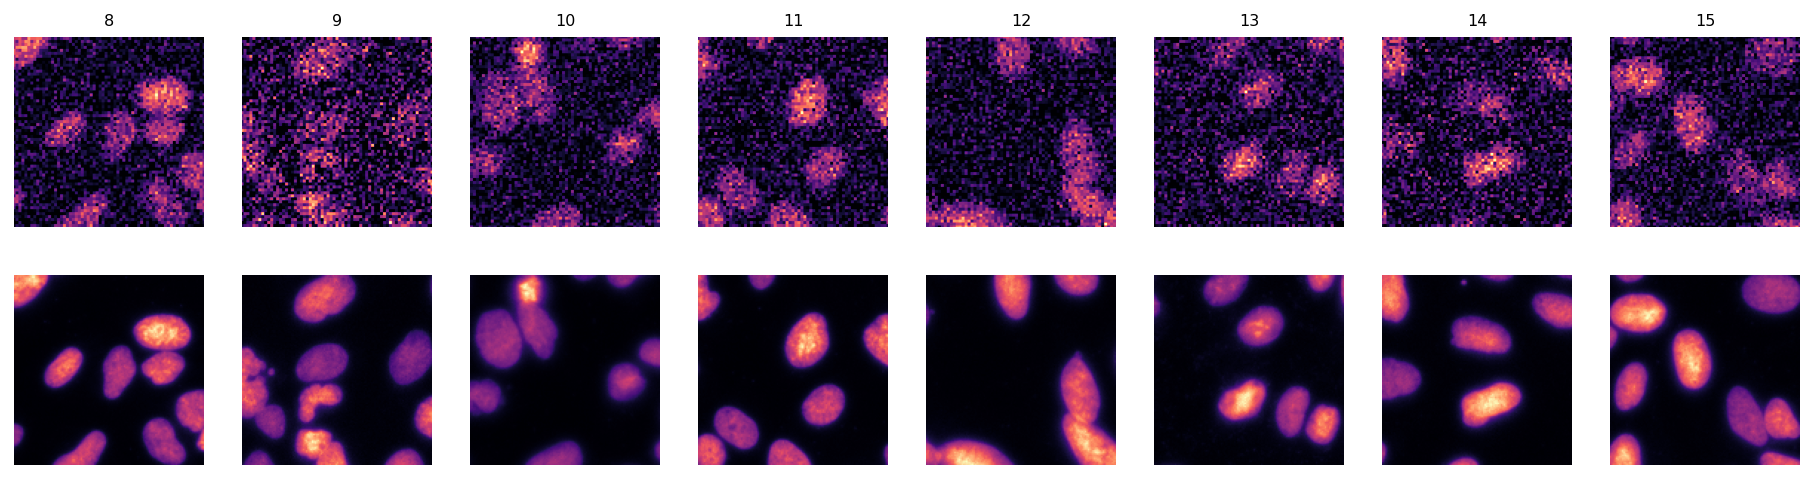

In [12]:
for i in range(2):
    plt.figure(figsize=(16,4))
    sl = slice(8*i, 8*(i+1)), 0
    plot_some(X[sl],Y[sl],title_list=[np.arange(sl[0].start,sl[0].stop)])
    plt.show()
None;

**Training**

In [13]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [14]:
from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE

In [15]:
(X,Y), (X_val,Y_val), axes = load_training_data('data/my_training_data.npz', validation_split=0.05, verbose=True)
c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

number of training images:	 4668
number of validation images:	 246
image size (2D):		 (128, 128)
axes:				 SYXC
channels in / out:		 1 / 1


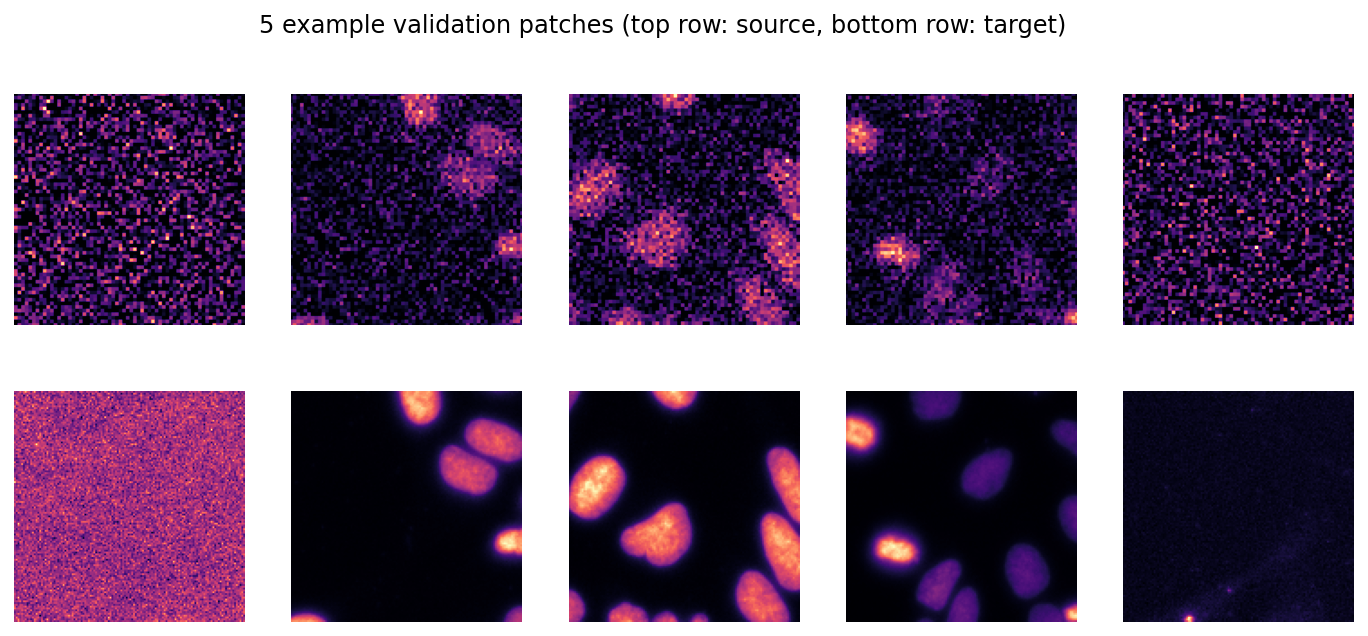

In [16]:
plt.figure(figsize=(12,5))
plot_some(X_val[:5],Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

                                                                      Care Model

In [17]:
config = Config(axes, n_channel_in, n_channel_out, unet_kern_size=3, train_batch_size=8, train_steps_per_epoch=40)
print(config)
vars(config)

Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=False, train_batch_size=8, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_epochs=100, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=40, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=3, unet_last_activation='linear', unet_n_depth=2, unet_n_first=32, unet_residual=True)


{'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'n_dim': 2,
 'probabilistic': False,
 'train_batch_size': 8,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_epochs': 100,
 'train_learning_rate': 0.0004,
 'train_loss': 'mae',
 'train_reduce_lr': {'factor': 0.5, 'min_delta': 0, 'patience': 10},
 'train_steps_per_epoch': 40,
 'train_tensorboard': True,
 'unet_input_shape': (None, None, 1),
 'unet_kern_size': 3,
 'unet_last_activation': 'linear',
 'unet_n_depth': 2,
 'unet_n_first': 32,
 'unet_residual': True}

In [18]:
model = CARE(config, 'my_model', basedir='models')

In [19]:
model.keras_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
down_level_0_no_0 (Conv2D)      (None, None, None, 3 320         input[0][0]                      
__________________________________________________________________________________________________
down_level_0_no_1 (Conv2D)      (None, None, None, 3 9248        down_level_0_no_0[0][0]          
__________________________________________________________________________________________________
max_0 (MaxPooling2D)            (None, None, None, 3 0           down_level_0_no_1[0][0]          
______________________________________________________________________________________________

                                                                   Training

In [20]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

Epoch 1/100
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x7f1cc362edd0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names.
Match 0:
(lambda x: K.mean(x, axis=(- 1)))

Match 1:
(lambda x: x)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x7f1cc362edd0>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names.
Match 0:
(lambda x: K.mean(x, axis=(- 1)))

Match 1:
(lambda x: x)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x7f1cc362eb00>: found multiple de

                                                              Loss Vs Validation-Loss Graph

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


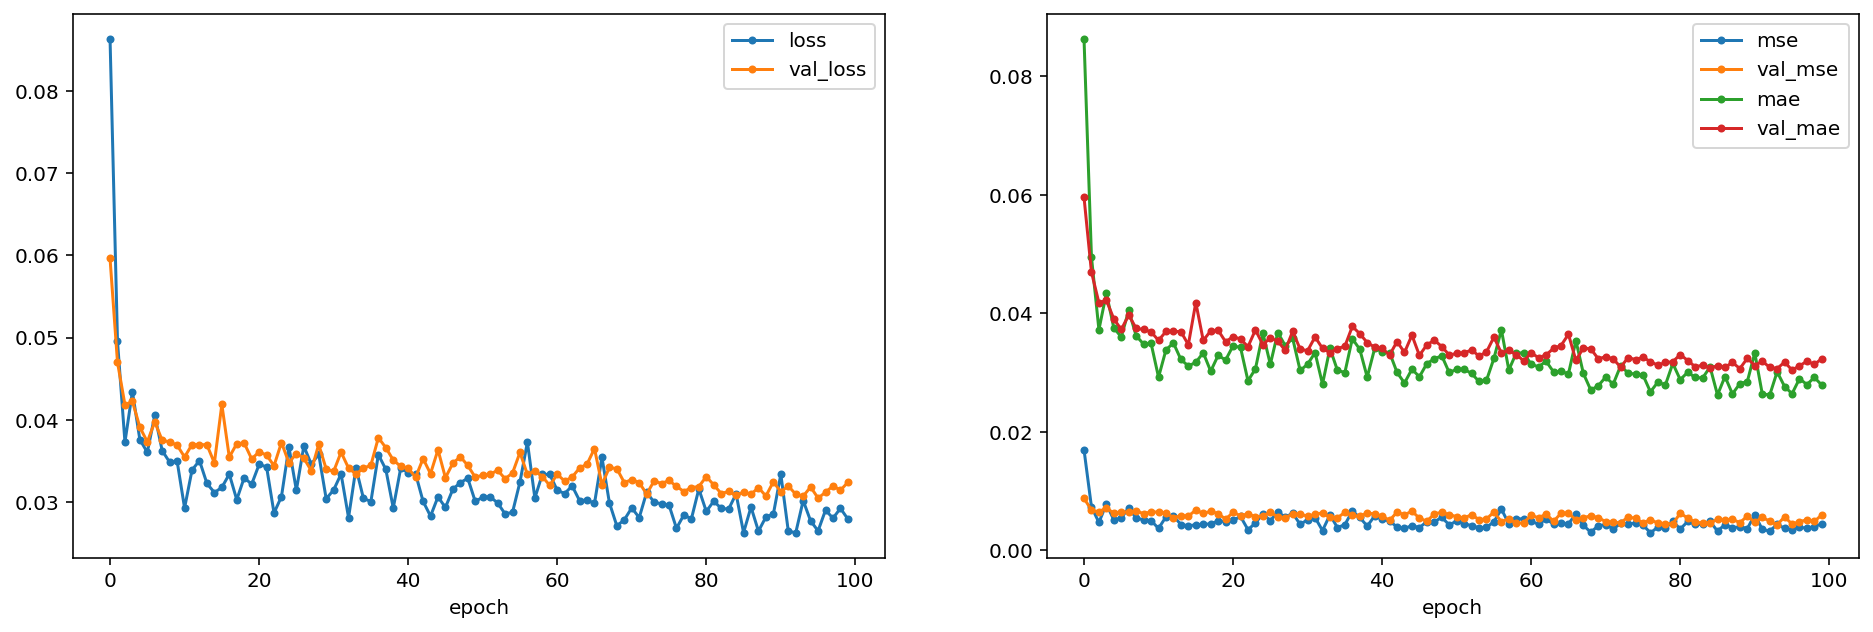

In [21]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

                                                                       Evaluation

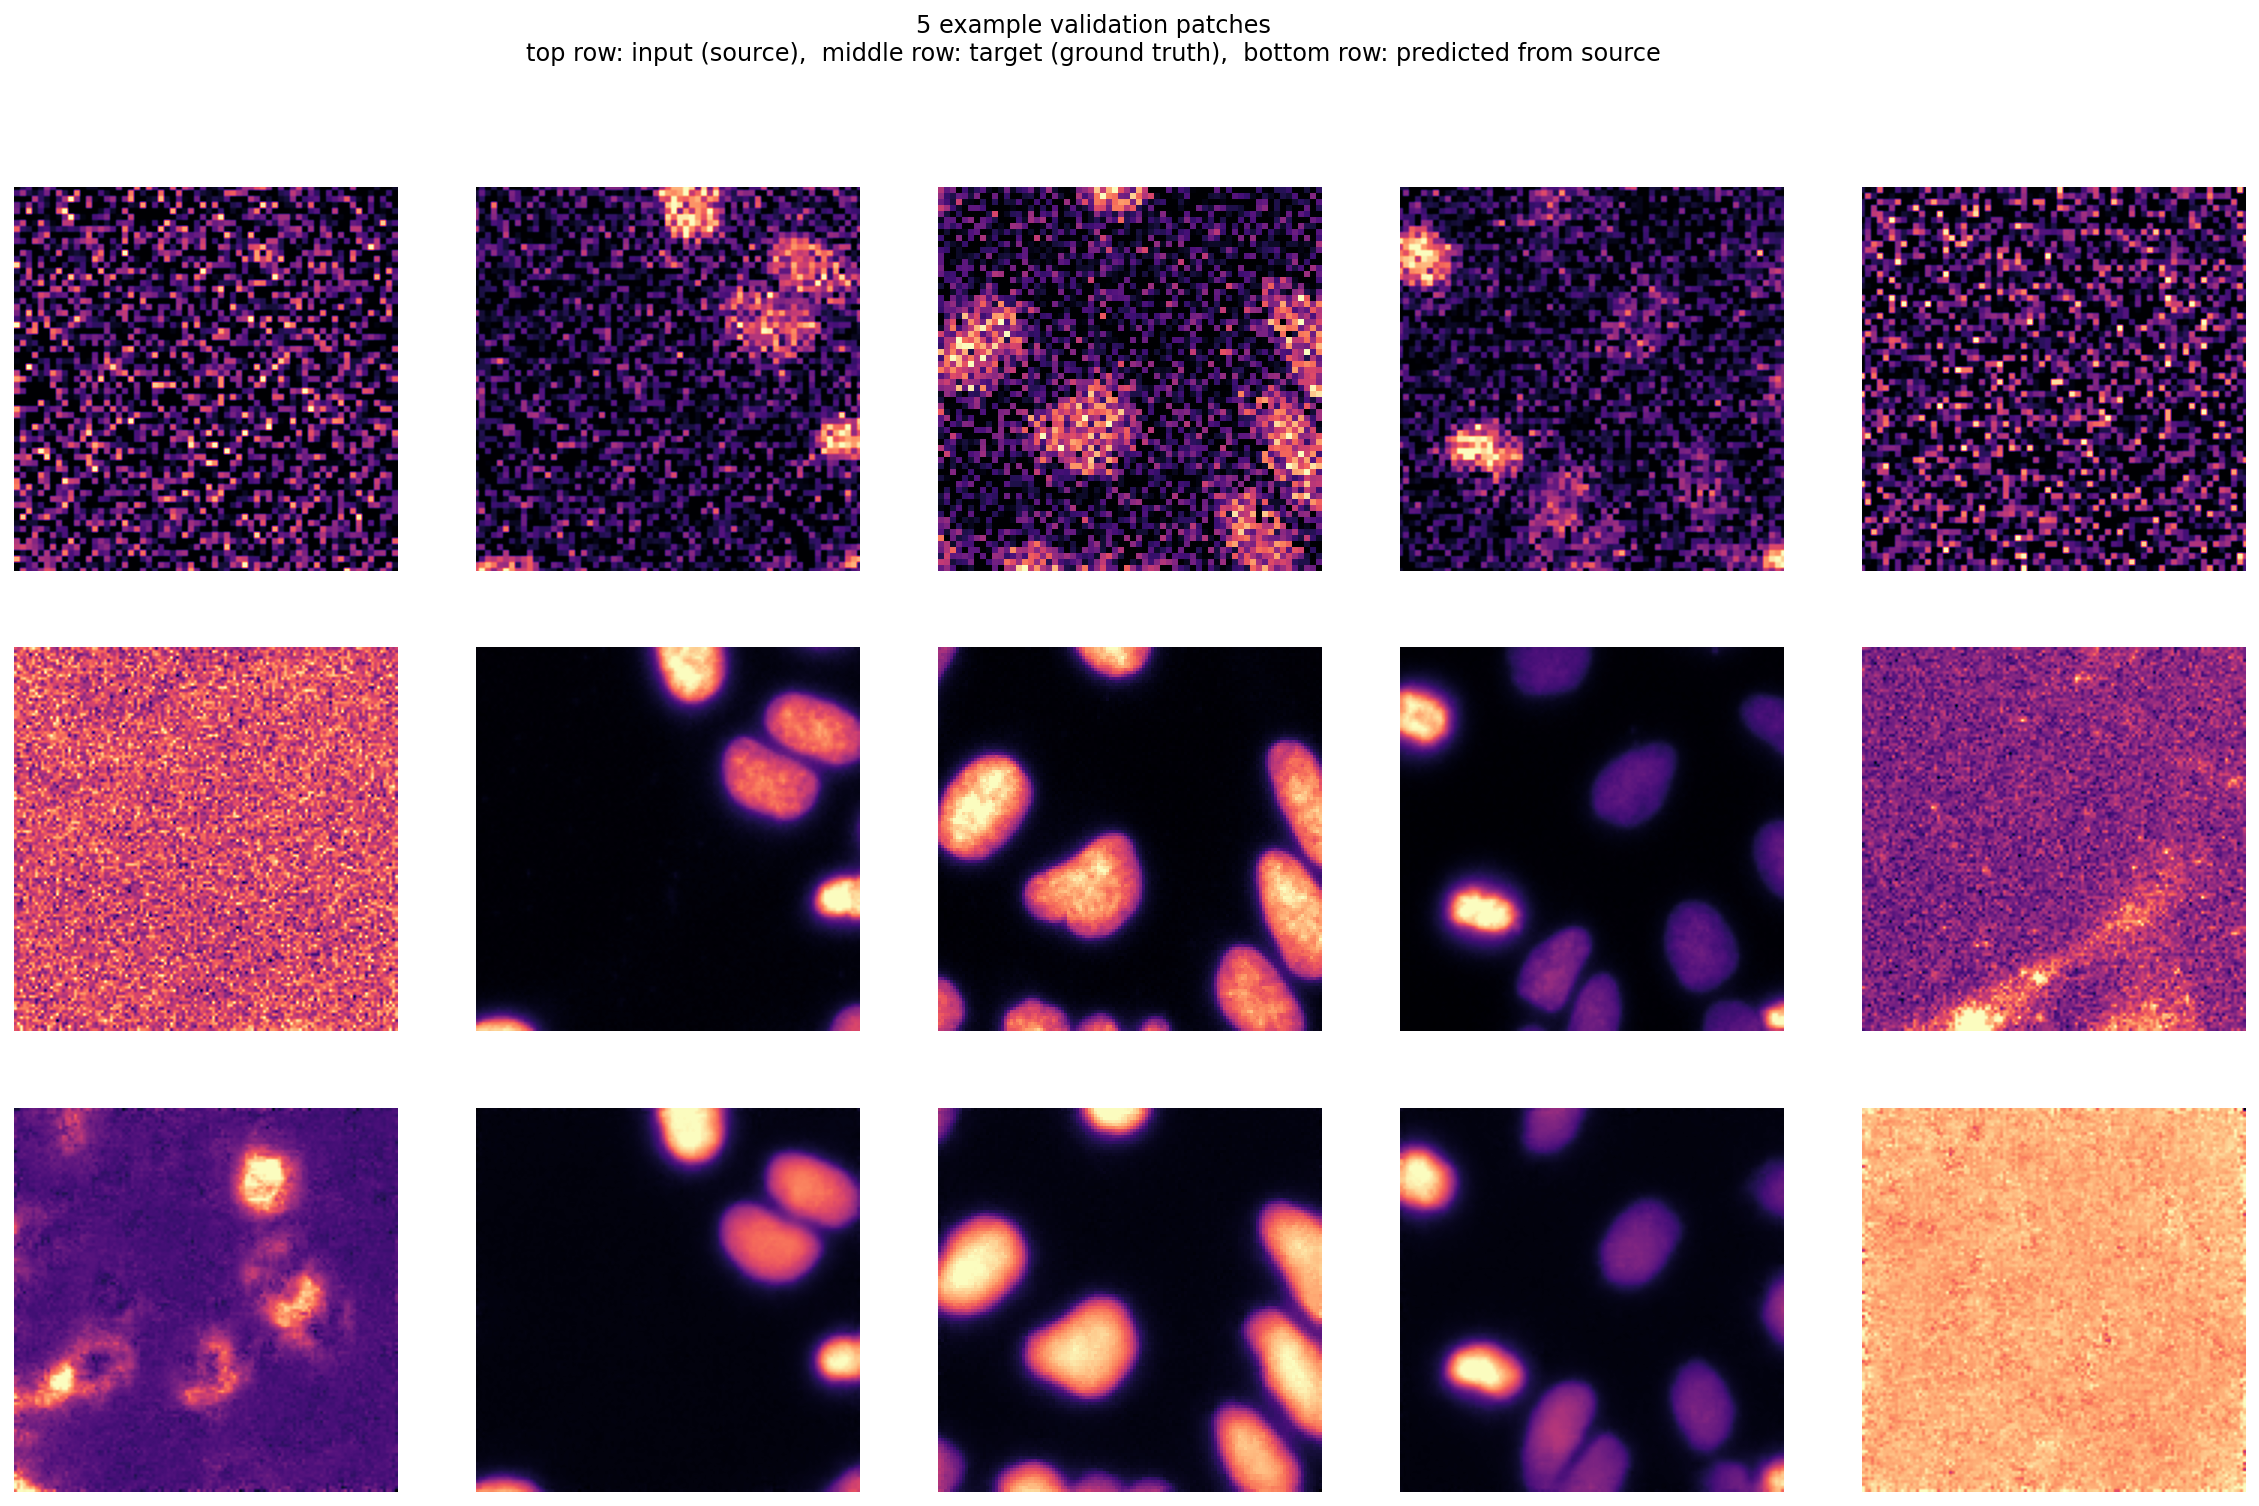

In [22]:
plt.figure(figsize=(20,12))
_P = model.keras_model.predict(X_val[:5])
if config.probabilistic:
    _P = _P[...,:(_P.shape[-1]//2)]
plot_some(X_val[:5],Y_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target (ground truth),  '
             'bottom row: predicted from source');

**Prediction**

In [23]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file, plot_some
from csbdeep.io import save_tiff_imagej_compatible
from csbdeep.models import CARE

                                               Raw low-SNR image and associated high-SNR ground truth

image size = (256, 256)
image axes = YX


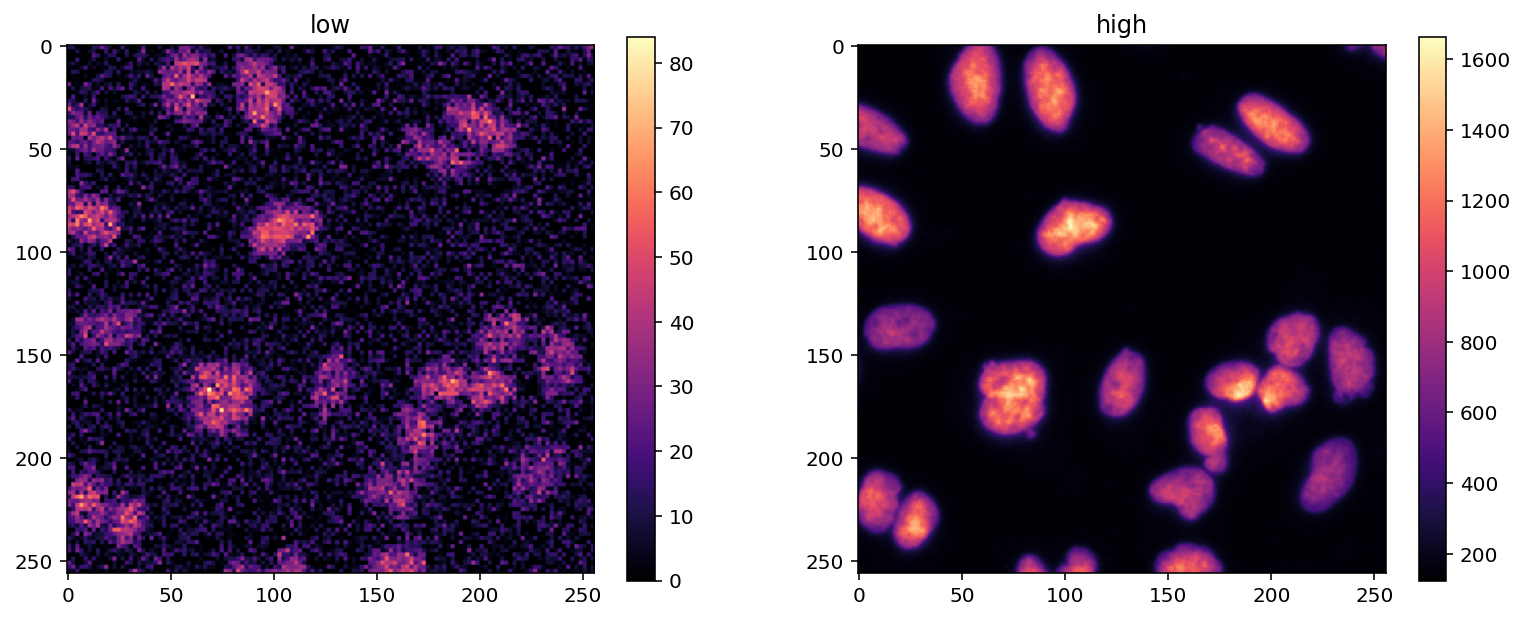

In [24]:
y = imread('data/test/GT/img_0010.tif')
x = imread('data/test/low/img_0010.tif')

axes = 'YX'
print('image size =', x.shape)
print('image axes =', axes)

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.imshow(x, cmap  ="magma")
plt.colorbar()
plt.title("low")
plt.subplot(1,2,2)
plt.imshow(y, cmap  ="magma")
plt.colorbar()
plt.title("high");

                                                                      CARE model

In [25]:
model = CARE(config=None, name='my_model', basedir='models')

Loading network weights from 'weights_best.h5'.


                                                          Apply CARE network to raw image

In [26]:
%%time
restored = model.predict(x, axes)

CPU times: user 583 ms, sys: 11 ms, total: 594 ms
Wall time: 386 ms


                                        Raw low/high-SNR image and denoised image via CARE network

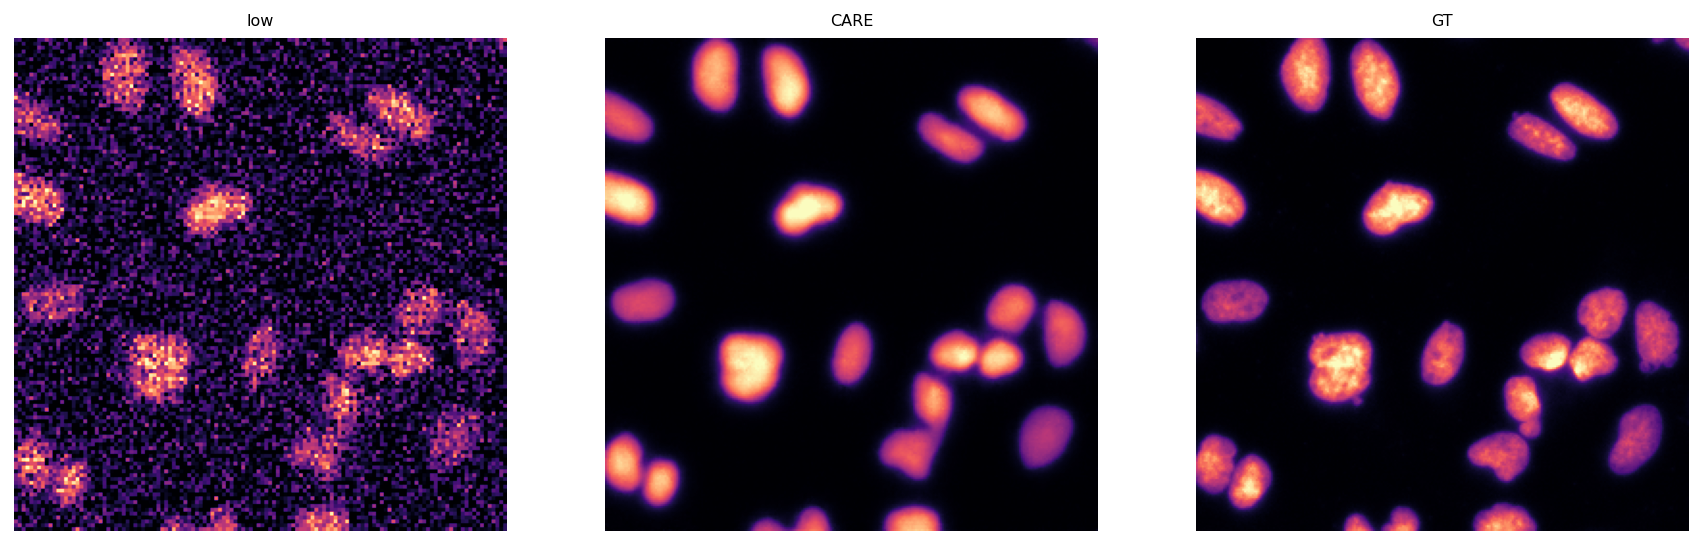

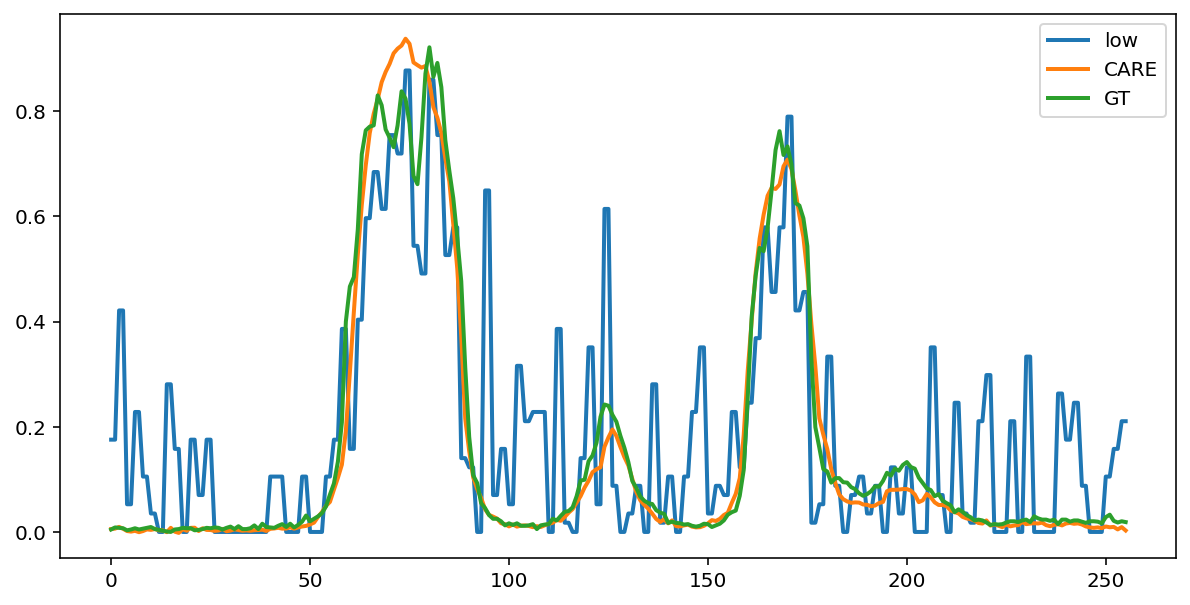

In [27]:
from csbdeep.utils import normalize

plt.figure(figsize=(15,10))
plot_some(np.stack([x,restored,y]),
          title_list=[['low','CARE','GT']], 
          pmin=2,pmax=99.8);

plt.figure(figsize=(10,5))
for _x,_name in zip((x,restored,y),('low','CARE','GT')):
    plt.plot(normalize(_x,1,99.7)[180], label = _name, lw = 2)

plt.legend();